<a href="https://colab.research.google.com/github/niconicode/AI-Budgie-Identifier/blob/main/MobileNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Classifier with Finetuned MobileNet V2 model**

MobileNet V2 model trained on imagenet-1k.

Mainly working from the finetuning example presented during the lab session.

1.) Loading the data from google drive, using the preprocessed images from phase 1

2.) Loading the model, adjusting the final layer to have 5 output classes and initializing the weights.

3.) Train and evalute the model. We tried different epochs, learning rates, and batch sizes.
- 10-15 epochs
- learning rate of 5e-5
- Batch size: 64
- Accuracy: ~85%

Tried other models that were too large to run.

Started with small batch size of 16 then 32. Both were too small and made the model take 2 minutes per epoch to train. Increasing the batch size to 64 reduced the iterations per epoch, greatly reducing the training time.

#**Load in Data**
- Downloads data from google drive
- y_train and y_test are converted into lists of ints y_train_list and y_test_list

**Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Load dataset from google drive**

In [ ]:
import zipfile
import os
zip_file_path = '/content/drive/My Drive/x_train.zip'
#zip_file_path = '/content/drive/MyDrive/AI_Data/x_train.zip'
extract_dir = '/content/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


zip_file_path = '/content/drive/My Drive/x_test.zip'
#zip_file_path = '/content/drive/MyDrive/AI_Data/x_test.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

**Open H5 Files**

In [ ]:
import h5py

y_train_h5_path = '/content/drive/My Drive/y_train.h5'
y_test_h5_path = '/content/drive/My Drive/y_test.h5'


# Open the HDF5 file for reading
with h5py.File(y_train_h5_path, 'r') as hf:
    # Read the dataset
    y_train = hf['y_train'][:]
    # Convert the dataset to a list of strings
    y_train_list = [str(item, 'utf-8') for item in y_train]
    y_train_list = [int(item) for item in y_train]

# Open the HDF5 file for reading
with h5py.File(y_test_h5_path, 'r') as hf:
    # Read the dataset
    y_test = hf['y_test'][:]
    # Convert the dataset to a list of strings
    y_test_list = [str(item, 'utf-8') for item in y_test]
    y_test_list = [int(item) for item in y_test]

# Open the HDF5 file for reading
with h5py.File('x_train.h5', 'r') as hf:
    # Read the dataset
    x_train = hf['x_train'][:]

# Open the HDF5 file for reading
with h5py.File('x_test.h5', 'r') as hf:
    # Read the dataset
    x_test = hf['x_test'][:]

**Visualize images + labels of testset and trainset**

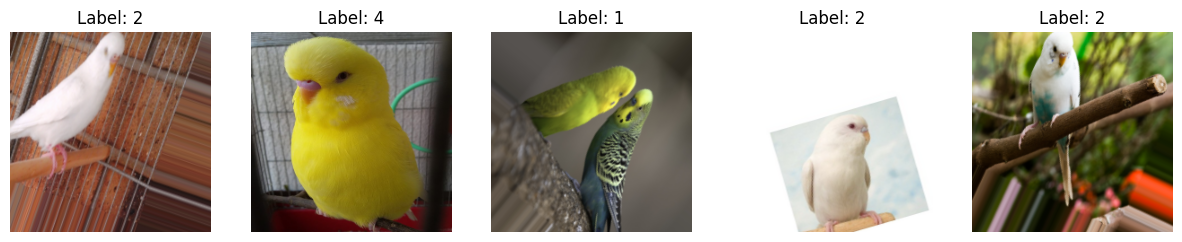

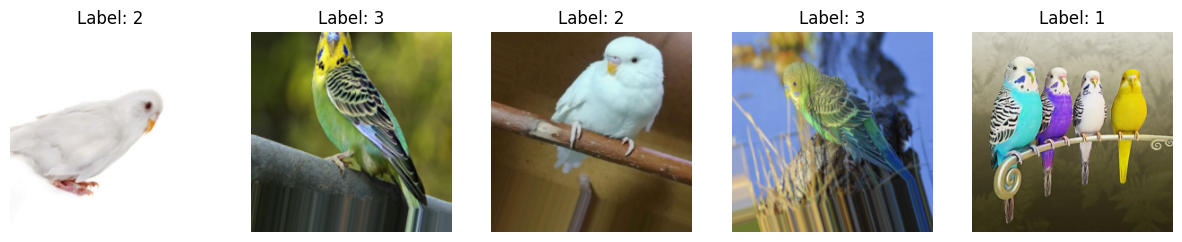

In [ ]:
import matplotlib.pyplot as plt

def visualize_images(images, labels):
    num_images = len(images)
    if num_images == 0:
        print("No images found in the HDF5 file.")
        return
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images[:5]):  # Visualize only the first 5 images
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Label: {}".format(labels[i]))
    plt.show()

visualize_images(x_test, y_test_list)
visualize_images(x_train, y_train_list)

**Libraries**

In [ ]:
!pip install datasets
!pip install category_encoders
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import datasets
import numpy as np
from category_encoders import OneHotEncoder
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from datasets import load_dataset
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification

# **Create Dataloaders**

Creates dataloaders for training and testing data from x_train and y_train_list, and x_test and y_test_list

- Code for a validation set is included but commented out. It currently requires validation data to be created in the phase 1 preprocessing colab, however it may be easier to simply split the test data here into test and validation
- Adjust batch_size here

In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (486, 224, 224, 3)
y_train shape: (486,)


In [ ]:
batch_size = 64

# convert to tensor
y_train_tensor = torch.LongTensor(y_train_list)

# Convert to tensor and transpose
x_train_tensor = torch.Tensor(x_train)
x_train_tensor = torch.transpose(x_train_tensor, 1, 3)

print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"x_train_tensor shape: {x_train_tensor.shape}")

# Create a TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

# Create a DataLoader
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

y_train_tensor shape: torch.Size([486])
x_train_tensor shape: torch.Size([486, 3, 224, 224])


**Visualize x_train_tensor**

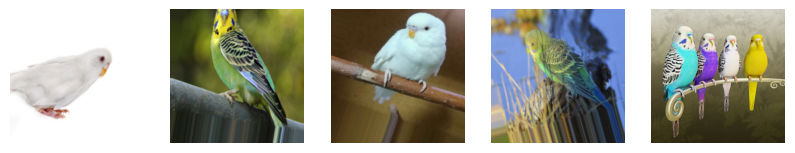

In [ ]:
import matplotlib.pyplot as plt

# Select the first 5 images
images = x_train_tensor[:5]

# Create a figure with a single row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(10, 5))

# Plot each image on its own subplot
for i, image in enumerate(images):
    image = image.permute(2, 1, 0)
    axes[i].imshow(image)
    axes[i].axis('off')

# Show the plot
plt.show()

**Test Dataset**

In [ ]:
# Convert to tensor
y_test_tensor = torch.LongTensor(y_test_list)

# Convert to tensor and transpose
x_test_tensor = torch.Tensor(x_test)
x_test_tensor = torch.transpose(x_test_tensor, 1, 3)

print(f"y_test_tensor shape: {y_test_tensor.shape}")
print(f"x_test_tensor shape: {x_test_tensor.shape}")

# Create a TensorDataset
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create a DataLoader
testloader = DataLoader(test_dataset, batch_size=batch_size)

y_test_tensor shape: torch.Size([209])
x_test_tensor shape: torch.Size([209, 3, 224, 224])


**Visualize x_test_tensor**

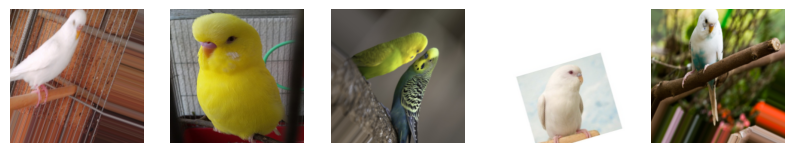

In [ ]:
import matplotlib.pyplot as plt

# Select the first 5 images
images = x_test_tensor[:5]

# Create a figure with a single row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(10, 5))

# Plot each image on its own subplot
for i, image in enumerate(images):
    image = image.permute(2, 1, 0)
    axes[i].imshow(image)
    axes[i].axis('off')

# Show the plot
plt.show()

#**Load Model**

Potentially could add dropout layers?

load mobilenet V2 model
- Adjust final layer of model to have 5 output classes

In [ ]:
import torch
import torchvision
import torch.nn as nn
from transformers import AutoModelForImageClassification
from transformers import ViTImageProcessor, ViTModel
import requests

# Load model
finetune_net = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_0.75_160")

finetune_net.classifier = nn.Linear(finetune_net.classifier.in_features, 5)     # 5 classes
nn.init.xavier_uniform_(finetune_net.classifier.weight);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#**Training and Testing Functions**

Training loop with functions to set device, evaluation with a confusion matrix, visualization of evaluated images, and fine tuning where loss, optimizer, etc. can be changed

**Function to set device**

In [ ]:
def try_all_gpus():
    """Return all available GPUs, or [cpu()], if no GPU exists."""
    if torch.cuda.is_available():
        devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
        return devices
    else:
        return [torch.device('cpu')]

**Training Loop**

In [ ]:
import time

def train_net(net, train_iter, test_iter, loss_fn, optimizer, num_epochs, devices):
    """Train and evaluate the network on multiple devices."""
    # Send the model to the device (multi-GPU or single GPU/CPU)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    # Training loop
    for epoch in range(num_epochs):
        net.train()  # Set the model to training mode
        train_loss_sum, n, start = 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(devices[0]), y.to(devices[0])  # Move data to the device
            optimizer.zero_grad()  # Zero the gradients
            y_hat = net(X)  # Forward pass
            y_hat = y_hat.logits
            loss = loss_fn(y_hat, y)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the model parameters
            train_loss_sum += loss.item()
            n += y.shape[0]

        # Evaluate the network
        print(f"Epoch {epoch+1}/{num_epochs}:")
        evaluate_with_confusion(net, test_iter, devices)
        print(f"Loss: {train_loss_sum / n:.3f}")
        print(f"Time:{time.time() - start:.1f} sec")
        print("="*30)

**Evaluate Accuracy** by comparing the predicted classes (y_hat) to the actual classes (y) and seeing how many the model got right.

In [ ]:
def evaluate_accuracy(net, data_iter, devices):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  # Set the model to evaluation mode
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    plot_images(X.cpu().numpy(), y.cpu().numpy(), y_hat.argmax(dim=1).cpu().numpy())

    return acc_sum / n

**Evaluate with Confusion Matrix**
- Plots 5 random test images with true and predicted labels to visualize accuracy

- Confusion matrix shows the number of true positivies, true negatives, false positives, and false negatives for the 5 classes

- Accuracy shows how much of the data was correctly classified

- Precision shows the percentage of the poisitve data points that were actually positive

- Recall shows the percentage of the positive data points that were correctly classified

- F1 score is the harmonic mean of precision and recall. Harmonic mean is used instead of the arithmetic mean because it penalizes extreme values more heavily. This means that a model with a high precision but low recall will have a lower F1 score than a model with a more balanced precision and recall.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to calculate metrics
def calculate_metrics(true_labels, predicted_labels):
  predicted_labels = torch.tensor(predicted_labels).argmax(dim=1).cpu().numpy()

  confusion = confusion_matrix(true_labels, predicted_labels)
  accuracy = accuracy_score(true_labels, predicted_labels)
  precision = precision_score(true_labels, predicted_labels, average='weighted')
  recall = recall_score(true_labels, predicted_labels, average='weighted')
  f1 = f1_score(true_labels, predicted_labels, average='weighted')
  return confusion, accuracy, precision, recall, f1

def evaluate_with_confusion(net, data_iter, devices):
    #test_images = []
    true_labels = []
    predicted_labels = []
    net.eval()  # Set the model to evaluation mode
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            y_hat = y_hat.logits

            #test_images = torch.tensor(X.cpu().numpy(), dtype=torch.float32)
            true_labels.extend(y.cpu().numpy())
            predicted_labels.extend(y_hat.cpu().numpy())

            # Plot 1 image for every batch with true and predicted labels
            plot_images(X.cpu().numpy(), y.cpu().numpy(), y_hat.argmax(dim=1).cpu().numpy())

    confusion, accuracy, precision, recall, f1 = calculate_metrics(true_labels, predicted_labels)

    print(f"Confusion Matrix:\n{confusion}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

**Visualize evaluated images** by randomly selecting test images and displaying them along with their true and predicted labels

In [ ]:
import random

def plot_images(images, labels, predictions, num_images=1):

  random_indices = random.sample(range(len(images)), min(len(images), num_images))
  selected_images = images[random_indices]
  selected_labels = labels[random_indices]
  selected_predictions = predictions[random_indices]

  plt.figure(figsize=(2, 2))
  for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(selected_images[i].transpose(2, 1, 0))
    plt.xlabel(f"Predicted: {selected_predictions[i]}, True: {selected_labels[i]}")
  plt.show()

**Fine tuning**

This is where we set devices, loss, and optimizer(trainer)

In [ ]:
def train_fine_tuning(net, learning_rate, batch_size=32, num_epochs=10):
    train_iter = trainloader
    test_iter = testloader
    devices = try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="sum")
    #trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
    #                          weight_decay=0.001)
    #trainer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    trainer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=0.01)
    train_net(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

#**Training Runs**

**RUN LOAD MODEL** before each train_fine_tuning call

- small batch size very slightly improves accuracy, by ~1%
- batch size 16, SGD optimizer: accuracy ~%90-91
- batch size 16, Adam optimizer: accuracy ~%96

## Run 1, batch size 16, optimizer SGD

In [ ]:
#batch size 16
train_fine_tuning(finetune_net, 5e-5, batch_size=batch_size, num_epochs=30)

Epoch 1/30:
Confusion Matrix:
[[ 7 17  4 23  2]
 [ 3 17  0 18  2]
 [ 7  8  6 24  0]
 [ 3  5  4 21  2]
 [ 4  7  9 16  3]]
Accuracy: 0.2547
Precision: 0.2830
Recall: 0.2547
F1 Score: 0.2248
Loss: 1.791
Time:2.3 sec
Epoch 2/30:
Confusion Matrix:
[[ 8 13  6 24  2]
 [ 4 22  0 10  4]
 [ 7  5 10 15  8]
 [ 1  5  0 26  3]
 [ 3  6  2 14 14]]
Accuracy: 0.3774
Precision: 0.4176
Recall: 0.3774
F1 Score: 0.3541
Loss: 1.463
Time:2.3 sec
Epoch 3/30:
Confusion Matrix:
[[27  2  7 16  1]
 [ 4 13  1 13  9]
 [ 9  0 26  6  4]
 [ 7  0  1 22  5]
 [ 3  2  4  4 26]]
Accuracy: 0.5377
Precision: 0.5866
Recall: 0.5377
F1 Score: 0.5381
Loss: 1.232
Time:2.4 sec
Epoch 4/30:
Confusion Matrix:
[[25 12  5  9  2]
 [ 2 27  2  6  3]
 [ 6  1 32  3  3]
 [ 3  3  3 24  2]
 [ 0  5  6  3 25]]
Accuracy: 0.6274
Precision: 0.6407
Recall: 0.6274
F1 Score: 0.6257
Loss: 1.078
Time:2.5 sec
Epoch 5/30:
Confusion Matrix:
[[24  7 11  8  3]
 [ 1 23  2  6  8]
 [ 6  0 35  1  3]
 [ 6  3  3 20  3]
 [ 1  2  5  2 29]]
Accuracy: 0.6179
Precision:

## Run 2 batch size 64, optimizer SGD

In [ ]:
train_fine_tuning(finetune_net, 5e-5, batch_size=batch_size, num_epochs=30)

Epoch 1/30:
Confusion Matrix:
[[ 4  7 19 13 10]
 [ 1  4 19  4 12]
 [ 0  1 35  5  4]
 [ 3  6 12  9  5]
 [ 0  4  5 10 20]]
Accuracy: 0.3396
Precision: 0.3502
Recall: 0.3396
F1 Score: 0.2881
Loss: 1.761
Time:2.2 sec
Epoch 2/30:
Confusion Matrix:
[[18 10  9  7  9]
 [ 6  9  2  4 19]
 [ 3  3 34  3  2]
 [ 7  8  1 15  4]
 [ 0  4  2  3 30]]
Accuracy: 0.5000
Precision: 0.4963
Recall: 0.5000
F1 Score: 0.4856
Loss: 1.419
Time:2.2 sec
Epoch 3/30:
Confusion Matrix:
[[17  7  7 17  5]
 [ 6 10  5 10  9]
 [ 2  1 33  5  4]
 [ 3  4  1 24  3]
 [ 0  2  2  9 26]]
Accuracy: 0.5189
Precision: 0.5391
Recall: 0.5189
F1 Score: 0.5050
Loss: 1.165
Time:2.5 sec
Epoch 4/30:
Confusion Matrix:
[[25 14  7  4  3]
 [ 7 22  1  4  6]
 [ 2  1 38  3  1]
 [ 8  5  1 16  5]
 [ 0  5  1  2 31]]
Accuracy: 0.6226
Precision: 0.6202
Recall: 0.6226
F1 Score: 0.6172
Loss: 0.962
Time:2.4 sec
Epoch 5/30:
Confusion Matrix:
[[28  9  5  7  4]
 [ 9 20  0  4  7]
 [ 3  2 35  3  2]
 [ 4  4  0 23  4]
 [ 0  3  0  3 33]]
Accuracy: 0.6557
Precision:

## Run 3 Batch size 16, Optimizer Adam, lr = 5e-5

In [ ]:
train_fine_tuning(finetune_net, 5e-5, batch_size=batch_size, num_epochs=18)

Epoch 1/18:
Confusion Matrix:
[[ 7 24 18  2  2]
 [ 0 28 10  1  1]
 [ 0  7 34  0  4]
 [ 3 14  8  8  2]
 [ 2 11 13  3 10]]
Accuracy: 0.4104
Precision: 0.4868
Recall: 0.4104
F1 Score: 0.3692
Loss: 1.688
Time:2.2 sec
Epoch 2/18:
Confusion Matrix:
[[14 21 15  3  0]
 [ 0 29  4  3  4]
 [ 0  4 40  0  1]
 [ 5 12  3 12  3]
 [ 2  1  3  1 32]]
Accuracy: 0.5991
Precision: 0.6304
Recall: 0.5991
F1 Score: 0.5737
Loss: 1.167
Time:2.1 sec
Epoch 3/18:
Confusion Matrix:
[[26 13  9  3  2]
 [ 0 28  1  5  6]
 [ 0  0 44  0  1]
 [ 3  8  2 20  2]
 [ 0  0  1  1 37]]
Accuracy: 0.7311
Precision: 0.7515
Recall: 0.7311
F1 Score: 0.7200
Loss: 0.837
Time:2.2 sec
Epoch 4/18:
Confusion Matrix:
[[31 14  5  3  0]
 [ 0 28  1  6  5]
 [ 1  0 43  0  1]
 [ 1  6  1 24  3]
 [ 0  0  0  0 39]]
Accuracy: 0.7783
Precision: 0.7970
Recall: 0.7783
F1 Score: 0.7739
Loss: 0.570
Time:2.8 sec
Epoch 5/18:
Confusion Matrix:
[[34  9  4  6  0]
 [ 2 25  0  7  6]
 [ 1  0 42  0  2]
 [ 1  4  0 29  1]
 [ 0  0  0  0 39]]
Accuracy: 0.7972
Precision:

## Run 4: batch size 16, optimizer Adam, lr: .001

Epoch 1/11:


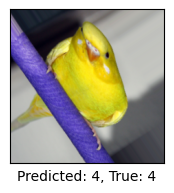

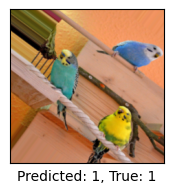

In [ ]:
train_fine_tuning(finetune_net, .001 , batch_size=batch_size, num_epochs=11)

## Run 5: batch size 16, optimizer AdamW, lr = .001, weight decay = .01

Epoch 1/20:


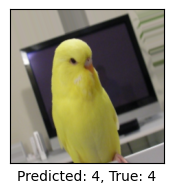

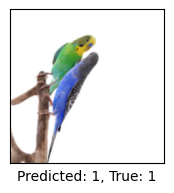

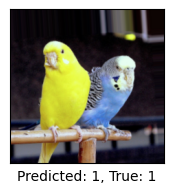

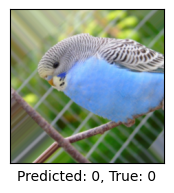

Confusion Matrix:
[[42  5  5  0  0]
 [ 2 34  0  3  3]
 [ 0  0 42  0  0]
 [ 0  0  1 31  3]
 [ 0  0  0  1 37]]
Accuracy: 0.8900
Precision: 0.8933
Recall: 0.8900
F1 Score: 0.8884
Loss: 0.789
Time:3.8 sec
Epoch 2/20:


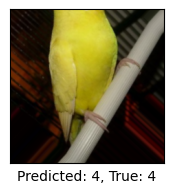

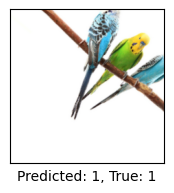

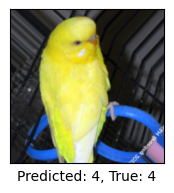

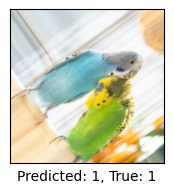

Confusion Matrix:
[[39  6  5  2  0]
 [ 0 38  0  3  1]
 [ 0  0 42  0  0]
 [ 0  1  0 30  4]
 [ 0  0  0  0 38]]
Accuracy: 0.8947
Precision: 0.9023
Recall: 0.8947
F1 Score: 0.8926
Loss: 0.073
Time:3.1 sec
Epoch 3/20:


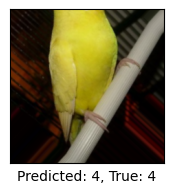

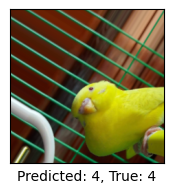

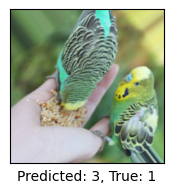

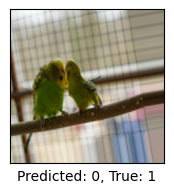

Confusion Matrix:
[[44  0  7  0  1]
 [ 5 26  0 11  0]
 [ 0  0 42  0  0]
 [ 0  0  1 32  2]
 [ 0  0  1  1 36]]
Accuracy: 0.8612
Precision: 0.8795
Recall: 0.8612
F1 Score: 0.8576
Loss: 0.068
Time:3.4 sec
Epoch 4/20:


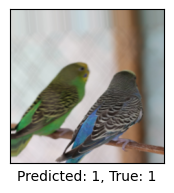

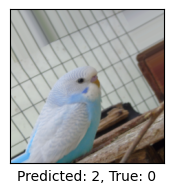

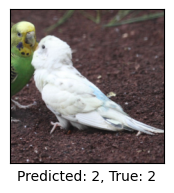

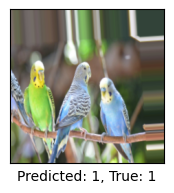

Confusion Matrix:
[[47  0  5  0  0]
 [ 1 37  0  4  0]
 [ 0  0 42  0  0]
 [ 0  1  0 33  1]
 [ 0  1  0  2 35]]
Accuracy: 0.9282
Precision: 0.9323
Recall: 0.9282
F1 Score: 0.9285
Loss: 0.047
Time:3.4 sec
Epoch 5/20:


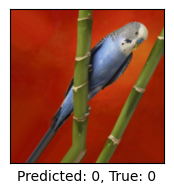

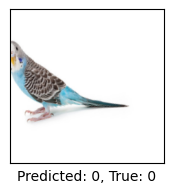

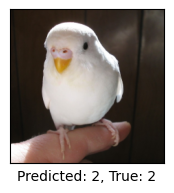

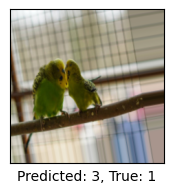

Confusion Matrix:
[[47  5  0  0  0]
 [ 2 31  0  9  0]
 [ 3  1 38  0  0]
 [ 0  0  1 33  1]
 [ 1  1  0  3 33]]
Accuracy: 0.8708
Precision: 0.8797
Recall: 0.8708
F1 Score: 0.8719
Loss: 0.096
Time:3.7 sec
Epoch 6/20:


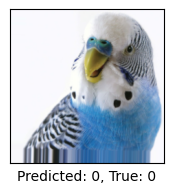

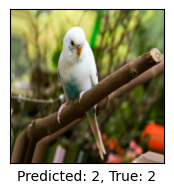

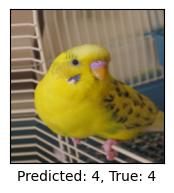

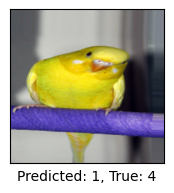

Confusion Matrix:
[[51  1  0  0  0]
 [ 3 37  0  2  0]
 [ 2  1 38  1  0]
 [ 0  0  0 35  0]
 [ 0  7  0  7 24]]
Accuracy: 0.8852
Precision: 0.9013
Recall: 0.8852
F1 Score: 0.8822
Loss: 0.096
Time:3.0 sec
Epoch 7/20:


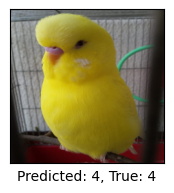

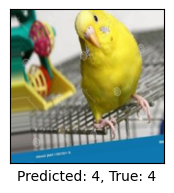

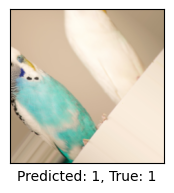

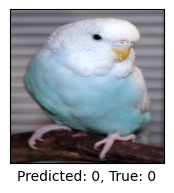

Confusion Matrix:
[[49  3  0  0  0]
 [ 1 40  0  1  0]
 [ 0  0 41  1  0]
 [ 0  2  1 31  1]
 [ 0  3  0  0 35]]
Accuracy: 0.9378
Precision: 0.9415
Recall: 0.9378
F1 Score: 0.9385
Loss: 0.034
Time:2.8 sec
Epoch 8/20:


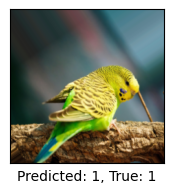

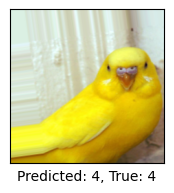

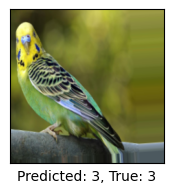

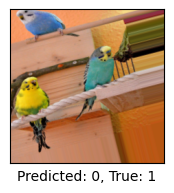

Confusion Matrix:
[[47  1  3  0  1]
 [ 2 34  0  5  1]
 [ 0  0 42  0  0]
 [ 0  0  0 35  0]
 [ 0  0  0  1 37]]
Accuracy: 0.9330
Precision: 0.9369
Recall: 0.9330
F1 Score: 0.9320
Loss: 0.040
Time:2.8 sec
Epoch 9/20:


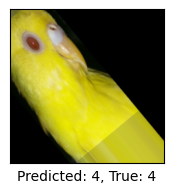

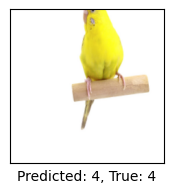

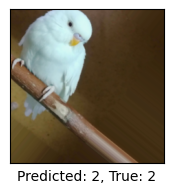

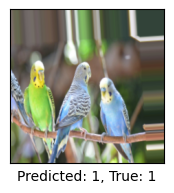

Confusion Matrix:
[[51  0  1  0  0]
 [ 1 40  0  1  0]
 [ 0  0 42  0  0]
 [ 0  1  0 34  0]
 [ 0  0  1  2 35]]
Accuracy: 0.9665
Precision: 0.9676
Recall: 0.9665
F1 Score: 0.9665
Loss: 0.022
Time:3.0 sec
Epoch 10/20:


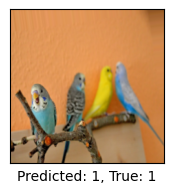

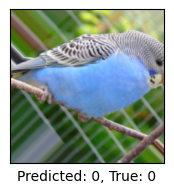

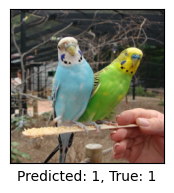

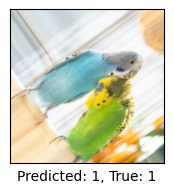

Confusion Matrix:
[[51  1  0  0  0]
 [ 1 41  0  0  0]
 [ 2  0 40  0  0]
 [ 0  0  0 34  1]
 [ 0  2  0  1 35]]
Accuracy: 0.9617
Precision: 0.9626
Recall: 0.9617
F1 Score: 0.9618
Loss: 0.019
Time:2.8 sec
Epoch 11/20:


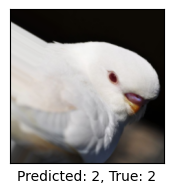

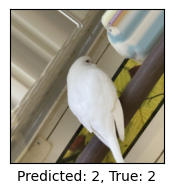

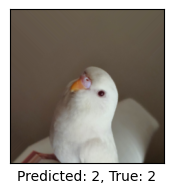

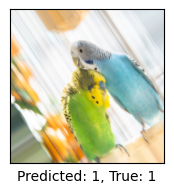

Confusion Matrix:
[[50  2  0  0  0]
 [ 1 41  0  0  0]
 [ 2  0 40  0  0]
 [ 0  2  0 32  1]
 [ 0  4  0  1 33]]
Accuracy: 0.9378
Precision: 0.9427
Recall: 0.9378
F1 Score: 0.9384
Loss: 0.003
Time:2.8 sec
Epoch 12/20:


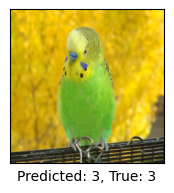

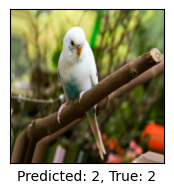

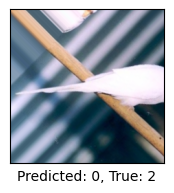

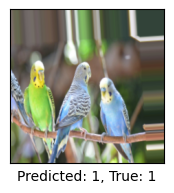

Confusion Matrix:
[[52  0  0  0  0]
 [ 0 42  0  0  0]
 [ 1  0 41  0  0]
 [ 0  0  0 34  1]
 [ 0  1  0  1 36]]
Accuracy: 0.9809
Precision: 0.9809
Recall: 0.9809
F1 Score: 0.9808
Loss: 0.005
Time:2.8 sec
Epoch 13/20:


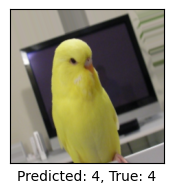

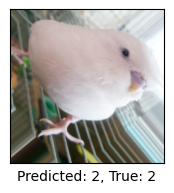

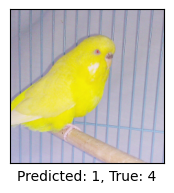

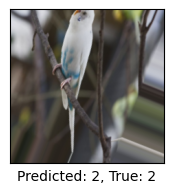

Confusion Matrix:
[[46  5  1  0  0]
 [ 0 42  0  0  0]
 [ 0  0 42  0  0]
 [ 0  2  0 33  0]
 [ 0  1  0  1 36]]
Accuracy: 0.9522
Precision: 0.9582
Recall: 0.9522
F1 Score: 0.9527
Loss: 0.004
Time:2.8 sec
Epoch 14/20:


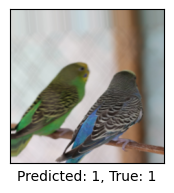

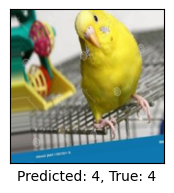

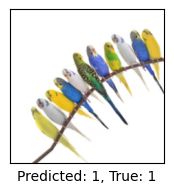

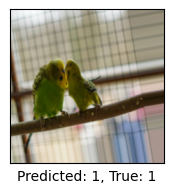

Confusion Matrix:
[[47  0  5  0  0]
 [ 0 41  0  1  0]
 [ 0  0 42  0  0]
 [ 0  0  0 35  0]
 [ 0  0  0  1 37]]
Accuracy: 0.9665
Precision: 0.9696
Recall: 0.9665
F1 Score: 0.9666
Loss: 0.004
Time:3.1 sec
Epoch 15/20:


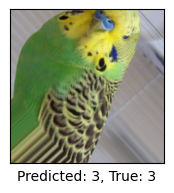

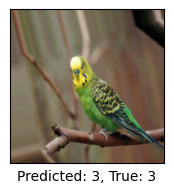

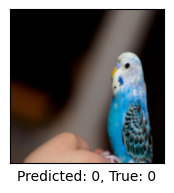

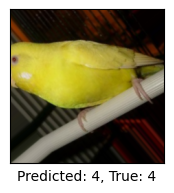

Confusion Matrix:
[[50  2  0  0  0]
 [ 0 42  0  0  0]
 [ 1  0 41  0  0]
 [ 0  0  0 34  1]
 [ 0  0  0  1 37]]
Accuracy: 0.9761
Precision: 0.9764
Recall: 0.9761
F1 Score: 0.9761
Loss: 0.001
Time:3.2 sec
Epoch 16/20:


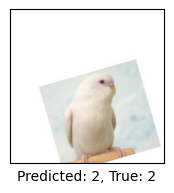

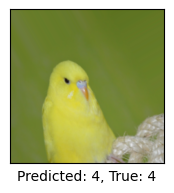

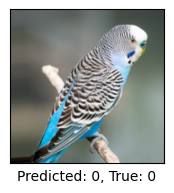

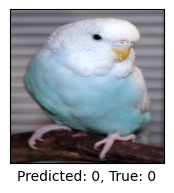

Confusion Matrix:
[[51  1  0  0  0]
 [ 0 42  0  0  0]
 [ 4  1 37  0  0]
 [ 0  0  0 34  1]
 [ 0  0  0  1 37]]
Accuracy: 0.9617
Precision: 0.9632
Recall: 0.9617
F1 Score: 0.9614
Loss: 0.001
Time:2.8 sec
Epoch 17/20:


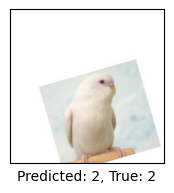

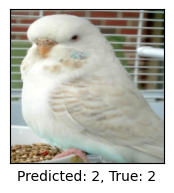

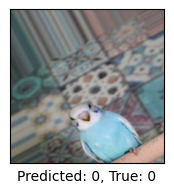

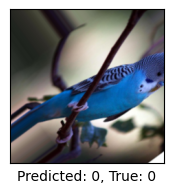

Confusion Matrix:
[[48  3  1  0  0]
 [ 0 42  0  0  0]
 [ 0  0 42  0  0]
 [ 0  0  0 34  1]
 [ 0  0  0  1 37]]
Accuracy: 0.9713
Precision: 0.9724
Recall: 0.9713
F1 Score: 0.9712
Loss: 0.001
Time:2.7 sec
Epoch 18/20:


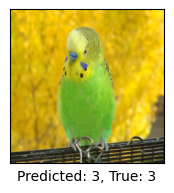

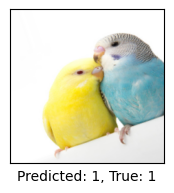

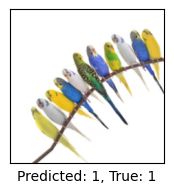

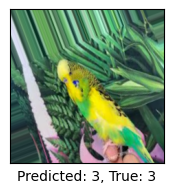

Confusion Matrix:
[[51  0  1  0  0]
 [ 1 39  0  2  0]
 [ 0  0 42  0  0]
 [ 0  0  0 34  1]
 [ 0  0  0  1 37]]
Accuracy: 0.9713
Precision: 0.9722
Recall: 0.9713
F1 Score: 0.9713
Loss: 0.001
Time:2.7 sec
Epoch 19/20:


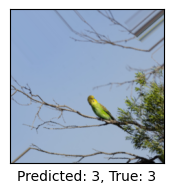

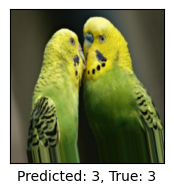

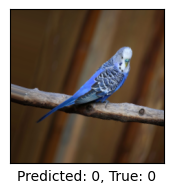

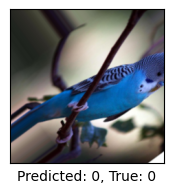

Confusion Matrix:
[[51  0  1  0  0]
 [ 1 41  0  0  0]
 [ 1  0 41  0  0]
 [ 0  0  0 35  0]
 [ 0  0  0  1 37]]
Accuracy: 0.9809
Precision: 0.9812
Recall: 0.9809
F1 Score: 0.9809
Loss: 0.000
Time:2.7 sec
Epoch 20/20:


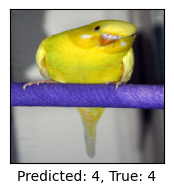

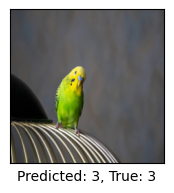

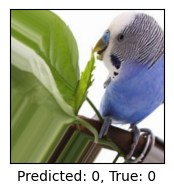

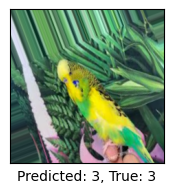

Confusion Matrix:
[[47  3  2  0  0]
 [ 0 42  0  0  0]
 [ 1  0 41  0  0]
 [ 0  0  0 33  2]
 [ 0  0  0  1 37]]
Accuracy: 0.9569
Precision: 0.9578
Recall: 0.9569
F1 Score: 0.9567
Loss: 0.002
Time:2.5 sec


In [ ]:
train_fine_tuning(finetune_net, .001, batch_size=batch_size, num_epochs=20)

## Run 6 Same as above but weight decay .05

Epoch 1/10:


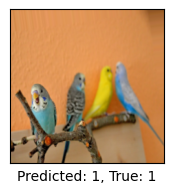

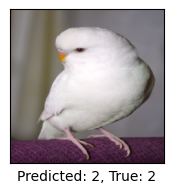

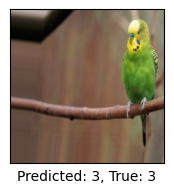

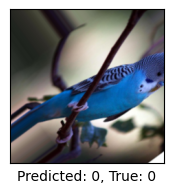

Confusion Matrix:
[[48  3  1  0  0]
 [ 0 29  1 12  0]
 [ 1  0 41  0  0]
 [ 0  0  0 35  0]
 [ 0  0  0  7 31]]
Accuracy: 0.8804
Precision: 0.9078
Recall: 0.8804
F1 Score: 0.8829
Loss: 0.858
Time:3.2 sec
Epoch 2/10:


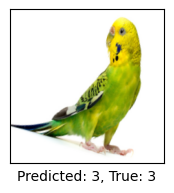

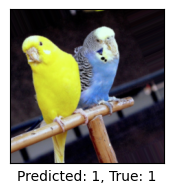

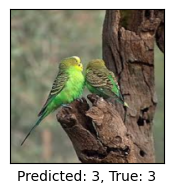

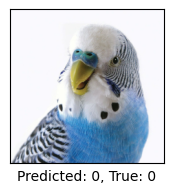

Confusion Matrix:
[[50  0  1  1  0]
 [ 0 39  0  3  0]
 [ 0  0 42  0  0]
 [ 0  1  0 32  2]
 [ 0  2  1  0 35]]
Accuracy: 0.9474
Precision: 0.9481
Recall: 0.9474
F1 Score: 0.9475
Loss: 0.087
Time:3.5 sec
Epoch 3/10:


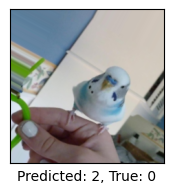

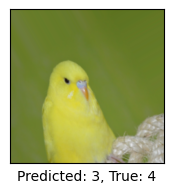

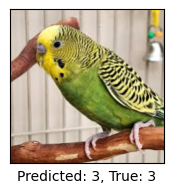

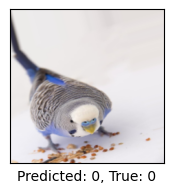

Confusion Matrix:
[[47  0  5  0  0]
 [ 1 35  0  5  1]
 [ 0  0 42  0  0]
 [ 0  0  0 34  1]
 [ 0  0  2  2 34]]
Accuracy: 0.9187
Precision: 0.9274
Recall: 0.9187
F1 Score: 0.9190
Loss: 0.040
Time:3.1 sec
Epoch 4/10:


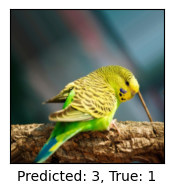

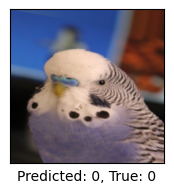

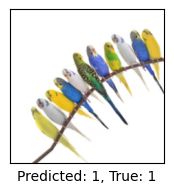

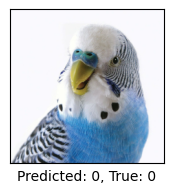

Confusion Matrix:
[[42  4  4  2  0]
 [ 0 32  0  6  4]
 [ 0  0 42  0  0]
 [ 0  0  0 35  0]
 [ 0  0  0  1 37]]
Accuracy: 0.8995
Precision: 0.9082
Recall: 0.8995
F1 Score: 0.8977
Loss: 0.018
Time:2.7 sec
Epoch 5/10:


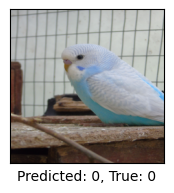

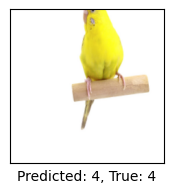

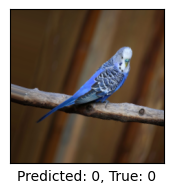

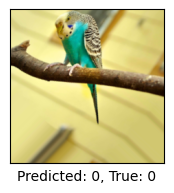

Confusion Matrix:
[[48  0  4  0  0]
 [ 7 32  0  1  2]
 [ 0  0 42  0  0]
 [ 2  1  0 31  1]
 [ 0  0  1  0 37]]
Accuracy: 0.9091
Precision: 0.9144
Recall: 0.9091
F1 Score: 0.9077
Loss: 0.012
Time:2.7 sec
Epoch 6/10:


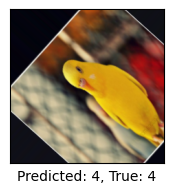

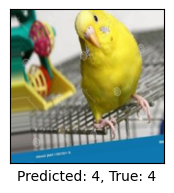

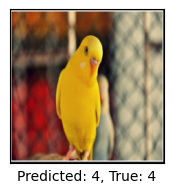

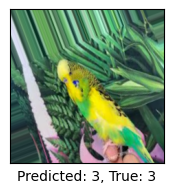

Confusion Matrix:
[[47  3  1  1  0]
 [ 0 39  0  3  0]
 [ 2  1 39  0  0]
 [ 0  0  0 35  0]
 [ 0  2  0  1 35]]
Accuracy: 0.9330
Precision: 0.9371
Recall: 0.9330
F1 Score: 0.9335
Loss: 0.007
Time:2.7 sec
Epoch 7/10:


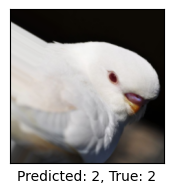

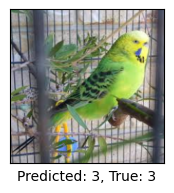

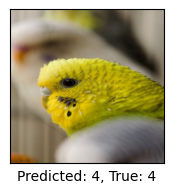

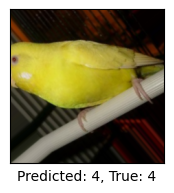

Confusion Matrix:
[[51  0  1  0  0]
 [ 5 32  0  4  1]
 [ 1  0 41  0  0]
 [ 0  0  0 32  3]
 [ 0  2  0  0 36]]
Accuracy: 0.9187
Precision: 0.9204
Recall: 0.9187
F1 Score: 0.9170
Loss: 0.009
Time:3.0 sec
Epoch 8/10:


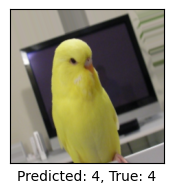

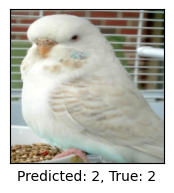

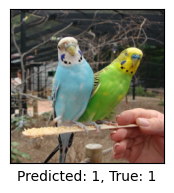

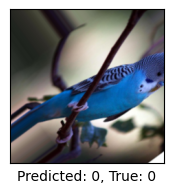

Confusion Matrix:
[[45  3  4  0  0]
 [ 0 38  0  2  2]
 [ 0  0 42  0  0]
 [ 0  0  0 33  2]
 [ 0  3  0  0 35]]
Accuracy: 0.9234
Precision: 0.9269
Recall: 0.9234
F1 Score: 0.9234
Loss: 0.009
Time:2.9 sec
Epoch 9/10:


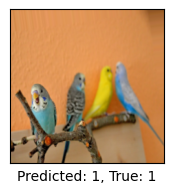

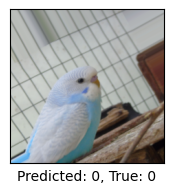

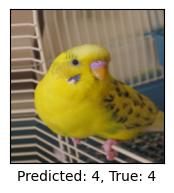

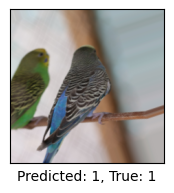

Confusion Matrix:
[[50  1  1  0  0]
 [ 1 38  0  3  0]
 [ 1  0 41  0  0]
 [ 0  1  0 34  0]
 [ 0  4  0  5 29]]
Accuracy: 0.9187
Precision: 0.9263
Recall: 0.9187
F1 Score: 0.9183
Loss: 0.003
Time:2.7 sec
Epoch 10/10:


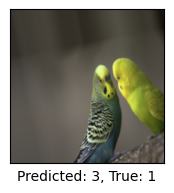

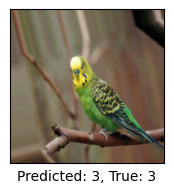

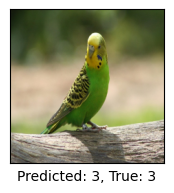

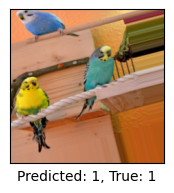

Confusion Matrix:
[[46  2  3  1  0]
 [ 0 39  0  3  0]
 [ 1  0 41  0  0]
 [ 0  1  0 34  0]
 [ 0  0  0  2 36]]
Accuracy: 0.9378
Precision: 0.9415
Recall: 0.9378
F1 Score: 0.9382
Loss: 0.012
Time:2.8 sec


In [ ]:
train_fine_tuning(finetune_net, .001, batch_size=batch_size, num_epochs=10)